In [2]:
from keras.applications import VGG16
from keras.applications import imagenet_utils

# from keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import load_img
from keras.layers import (
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    Activation,
    GlobalAveragePooling2D,
)
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
import os
import cv2
import pickle
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from keras.layers import BatchNormalization

In [3]:
model = VGG16(include_top=False, input_shape=(48, 144, 3), pooling=None)

In [4]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 144, 3)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 144, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 144, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 72, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 72, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 72, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 36, 128)       0     

In [5]:
for l in model.layers[:-4]:
    l.trainable = False

In [ ]:
a = GlobalAveragePooling2D()(model.output)

a = Dense(256, use_bias=False)(a)
a = BatchNormalization()(a)
a = Activation("relu")(a)
a = Dropout(0.5)(a)


def shared_branch(a, name):
    # لایه‌های اشتراکی برای تمام branchها
    x = Dense(128, use_bias=False)(a)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)

    # لایه‌های خاص هر branch
    x = Dense(64, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.2)(x)

    return Dense(32, activation="softmax", name=name)(x)


out1 = shared_branch(a, "out1")
out2 = shared_branch(a, "out2")
out3 = shared_branch(a, "out3")
out4 = shared_branch(a, "out4")
from keras.optimizers import Adam

model2 = Model(model.input, outputs=[out1, out2, out3, out4])
model2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={
        "out1": "categorical_crossentropy",
        "out2": "categorical_crossentropy",
        "out3": "categorical_crossentropy",
        "out4": "categorical_crossentropy",
    },
    loss_weights={"out1": 1.0, "out2": 1.5, "out3": 1.5, "out4": 1.1},
    metrics={
        "out1": ["accuracy"],
        "out2": ["accuracy"],
        "out3": ["accuracy"],
        "out4": ["accuracy"],
    },
)

In [7]:
model2.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 144, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 block1_conv1 (Conv2D)          (None, 48, 144, 64)  1792        ['input_1[0][0]']                
                                                                                                  
 block1_conv2 (Conv2D)          (None, 48, 144, 64)  36928       ['block1_conv1[0][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 24, 72, 64)   0           ['block1_conv2[0][0]']       

In [8]:
with open('encoder.bin','rb')as f:
    encoder = pickle.load(f)

In [9]:
encoder.classes_

array(['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E',
       'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T',
       'U', 'V', 'W', 'X', 'Y', 'Z'], dtype='<U1')

In [10]:
# def datagenerator(path, batch_size=100):
#     pattern= os.path.join(path,'*.png')
#     fills= glob(pattern)
#     while True:
#         offset=0
#         while offset<len(fills):
#             items = fills[offset:offset+batch_size]
#             offset+=batch_size
#             x = []
#             y1 = []
#             y2 = []
#             y3 = []
#             y4 = []
#             for f in items:
#                 char = list(os.path.splitext(os.path.basename(f))[0])
#                 if len(char)!=4:
#                     continue
#                 im = cv2.imread(f)
#                 im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
#                 im = cv2.resize(im,(144,48)).astype(np.float32)
#                 im = imagenet_utils.preprocess_input(im)
#                 x.append(im)
#                 char = [to_categorical(encoder.transform([i]),num_classes=len(encoder.classes_)).reshape(-1) for i in char]
#                 y1.append(char[0])
#                 y2.append(char[1])
#                 y3.append(char[2])
#                 y4.append(char[3])
#             X = np.array(x,ndmin=4)
#             Y1 = np.array(y1)
#             Y2 = np.array(y2)
#             Y3 = np.array(y3)
#             Y4 = np.array(y4)
#             yield X,(Y1,Y2,Y3,Y4)

In [11]:
# data = datagenerator('train')
# for x,y in data:
#     print(len(x),len(y))
#     # print(x.shape,y.shape)

In [12]:
# # تعریف output_signature برای ۴ خروجی
# num_classes = len(encoder.classes_)
# output_signature = (
#     tf.TensorSpec(shape=(None, 48, 144, 3), dtype=tf.float32),  # ورودی تصویر
#     (
#         tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32),  # Y1
#         tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32),  # Y2
#         tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32),  # Y3
#         tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)   # Y4
#     )
# )


# def create_dataset(path, batch_size=100):
#     def gen():
#         return datagenerator(path, batch_size)

#     dataset = tf.data.Dataset.from_generator(
#         gen,
#         output_signature=output_signature
#     )
#     return dataset



In [13]:
# train_dir = 'train'
# val_dir   = 'test'

# batch_size = 100
# steps_per_epoch  = max(1, len(glob(train_dir+'/*.png')) // batch_size)
# val_steps        = max(1, len(glob(val_dir  +'/*.png')) // batch_size)

# # h = model2.fit(
# #     datagenerator(train_dir, batch_size=batch_size),
# #     steps_per_epoch=steps_per_epoch,
# #     epochs=40
# # )



# train_dataset = create_dataset(train_dir, batch_size)
# val_dataset = create_dataset(val_dir, batch_size)

# h = model2.fit(
#     train_dataset,
#     steps_per_epoch=steps_per_epoch,
#     epochs=50,
#     validation_data=val_dataset,
#     validation_steps=val_steps
# )

In [14]:
def load_data(p):
    pattern = os.path.join(p, "*.png")
    files = glob(pattern)
    x = []
    y1 = []
    y2 = []
    y3 = []
    y4 = []
    for f in files:
        char = list(os.path.splitext(os.path.basename(f))[0])
        if len(char) != 4:
            continue
        im = cv2.imread(f)
        # im = img_to_array(im)
        im = cv2.resize(im, (144, 48))
        im = imagenet_utils.preprocess_input(im)

        x.append(im)
        char = [
            to_categorical(encoder.transform([i])[0], num_classes=len(encoder.classes_))
            for i in char
        ]

        y1.append(char[0])
        y2.append(char[1])
        y3.append(char[2])
        y4.append(char[3])
    X = np.array(x, ndmin=4)
    Y1 = np.array(y1)
    Y2 = np.array(y2)
    Y3 = np.array(y3)
    Y4 = np.array(y4)
    return X, Y1, Y2, Y3, Y4


x_train, Y1, Y2, Y3, Y4 = load_data("../2_1_Convolutional/train/")
h = model2.fit(x_train, {"out1": Y1, "out2": Y2, "out3": Y3, "out4": Y4}, epochs=20)

Epoch 1/20
308/308 [==============================] - 56s 150ms/step - loss: 18.3899 - out1_loss: 3.6138 - out2_loss: 3.6533 - out3_loss: 3.7146 - out4_loss: 3.7243 - out1_accuracy: 0.0529 - out2_accuracy: 0.0447 - out3_accuracy: 0.0432 - out4_accuracy: 0.0399
Epoch 2/20
308/308 [==============================] - 42s 136ms/step - loss: 17.0027 - out1_loss: 3.2398 - out2_loss: 3.3775 - out3_loss: 3.4421 - out4_loss: 3.5335 - out1_accuracy: 0.1106 - out2_accuracy: 0.0846 - out3_accuracy: 0.0750 - out4_accuracy: 0.0584
Epoch 3/20
308/308 [==============================] - 42s 136ms/step - loss: 15.8873 - out1_loss: 2.9288 - out2_loss: 3.1549 - out3_loss: 3.2585 - out4_loss: 3.3386 - out1_accuracy: 0.1906 - out2_accuracy: 0.1360 - out3_accuracy: 0.1099 - out4_accuracy: 0.0863
Epoch 4/20
308/308 [==============================] - 49s 159ms/step - loss: 14.8479 - out1_loss: 2.6590 - out2_loss: 2.9487 - out3_loss: 3.0552 - out4_loss: 3.1830 - out1_accuracy: 0.2694 - out2_accuracy: 0.1920 - ou

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


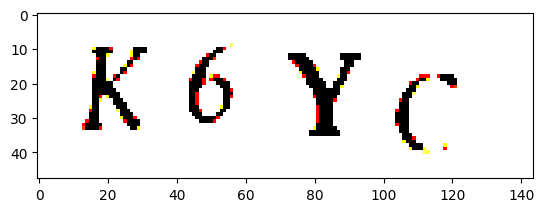

In [34]:
f = "../2_1_Convolutional/test/K6YC.png"
im = cv2.imread(f)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (144, 48))
f = imagenet_utils.preprocess_input(im)
# f = cv2.resize(f,(144,48))
# f.shape
plt.imshow(f)

In [35]:
p = model2.predict(f.reshape(1,48,144,3))


1/1 [==============================] - 0s 48ms/step


In [36]:
for i in p:
    # print(np.argmax(i))
    print(encoder.inverse_transform([np.argmax(i)]))

['K']
['6']
['Y']
['C']


In [19]:
model2.save('model2.keras')